# Table of Contents
 <p>

In [2]:
import os
os.chdir('../..')

In [4]:
from spikelearn import io, select, to_feature_array, SHORTCUTS

In [13]:
for label in SHORTCUTS['groups']['DRRD']:
    data = 
    print(data)

654
454
504
1030


In [31]:
import numpy as np
import pandas as pd

In [21]:
n_trials = np.min([select(io.load(label, 'wide_smoothed'), _min_duration=1.5).reset_index().trial.nunique() for label in SHORTCUTS['groups']['DRRD']])

In [45]:
subset='cropped'

In [68]:
dsets = [select(io.load(label, 'wide_smoothed'), _min_duration=1.5) for label in SHORTCUTS['groups']['DRRD']]

n_trials = np.min([ds.reset_index().trial.nunique() for ds in dsets])
n_bins = dsets[0][subset].apply(len).min()

df = pd.concat([to_feature_array(ds).reset_index('trial', drop=True).iloc[:n_trials*n_bins] for ds in dsets],axis=1)
df['trial'] = np.hstack([n_bins*[i] for i in range(n_trials)])
df = df.reset_index().set_index(['trial','time'])

In [70]:
from spikelearn import shuffle_val_predict

In [71]:
from sklearn.linear_model import LogisticRegression

In [75]:
res = shuffle_val_predict(LogisticRegression(), df, '1')

['1']


In [76]:
%matplotlib inline

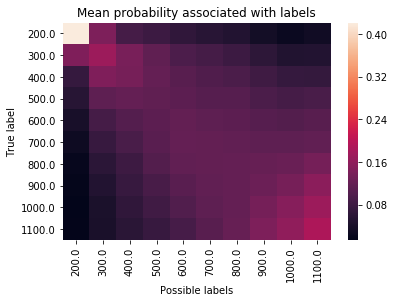

In [80]:
res.proba_matrix();

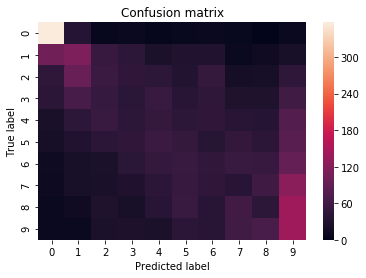

In [81]:
res.confusion_matrix();